In [106]:

import sys 
sys.path.append('..')

import os
import pytorch_lightning as pl
from src.models.multimodal.flamingo_module import FlamingoModule
from src.datasets.mimic_cxr_rachet import MIMICCXRRachetDataModule
from src.utils.utils import load_flamingo_weights, print_hyperparams

from pytorch_lightning import Trainer, seed_everything
import torchvision.transforms as T
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch



# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
seed_everything(42, workers=True)

# Mean and std of the dataset
# mean: tensor([0.2570, 0.2570, 0.2570])
# std:  tensor([0.2710, 0.2712, 0.2711])
augmentations = {

    'train': T.Compose([T.Resize((224,224)),
                        T.ToTensor(),
                       # T.RandomHorizontalFlip(p=0.5),
                        T.RandomRotation(degrees=10),
                         T.Normalize(mean=(0.4719, 0.4719, 0.4719), std=(0.3029, 0.3029, 0.3029))
                        ]),
    'val': T.Compose([T.Resize((224,224)),
                        T.ToTensor(),
                       # T.RandomHorizontalFlip(p=0.5),
                        #T.RandomRotation(degrees=10),
                         T.Normalize(mean=(0.4719, 0.4719, 0.4719), std=(0.3029, 0.3029, 0.3029))
                        ]),
    'test': T.Compose([T.Resize((224,224)),
                        T.ToTensor(),
                       # T.RandomHorizontalFlip(p=0.5),
                        T.RandomRotation(degrees=10),   
                        T.Normalize(mean=(0.4719, 0.4719, 0.4719), std=(0.3029, 0.3029, 0.3029))
                        ])
}



# Hyperparameters
NUM_DATA_WORKERS  = 4
ONLY_IMAGES = False
BATCH_SIZE = 1
NUM_EPOCHS = 200
LIMIT_NUM_SAMPLES = None

if os.getcwd().startswith('/home/mlmi-matthias'):
    ACCELERATOR = "gpu"
    DEVICES = [5,6]
    PRETRAINED_CLIP_PATH = '/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth'
    PRETRAINED_GPT2_PATH = "/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin"
    MIMIC_CXR_DCM_PATH = '/home/mlmi-matthias/physionet.org/files/mimic-cxr/2.0.0/files/'
    MIMIC_CXR_JPG_PATH = "/home/mlmi-matthias/physionet.org/files/mimic-cxr-jpg/2.0.0/files/"
    SPLIT_PATH = '/home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/'
    MIMIC_ROOT = '/home/mlmi-matthias/physionet.org/'

elif os.getcwd().startswith('/Users/caghankoksal'):
    PRETRAINED_CLIP_PATH = '/Users/caghankoksal/Desktop/development/PubMedCLIP_ViT32.pth'
    PRETRAINED_GPT2_PATH = "/Users/caghankoksal/Desktop/development/TransformerPlay/gpt2-pytorch_model.bin"
    ACCELERATOR = "cpu"
    DEVICES = 1
    MIMIC_CXR_DCM_PATH = '/Users/caghankoksal/Desktop/development/Flamingo-playground/physionet.org/files/mimic-cxr/2.0.0/files/'
    MIMIC_CXR_JPG_PATH = '/Users/caghankoksal/Desktop/development/physionet.org/files/mimic-cxr-jpg/2.0.0/files/'
    SPLIT_PATH = '/Users/caghankoksal/Desktop/SS2022/mlmi-vqa/data/external/'


IMAGE_TYPE = "jpg"
TOKENIZER  = "gpt2"
PREPROCESSED = True




dataset_hyperparameters = {
    "split_path":SPLIT_PATH,
    "mimic_root": MIMIC_ROOT,
    "batch_size": BATCH_SIZE,
    "tokenizer": TOKENIZER,
    "num_data_workers": NUM_DATA_WORKERS,
    "transforms": augmentations,
    "limit_num_samples": LIMIT_NUM_SAMPLES,
}



datamodule = MIMICCXRRachetDataModule(**dataset_hyperparameters)


train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()

print("Len training dataset : ", len(datamodule.train_dataset),
    "Batch Size : ", BATCH_SIZE, "NUM_EPOCHS : ",NUM_EPOCHS )
print("Total training steps : ", len(datamodule.train_dataset)//BATCH_SIZE*NUM_EPOCHS)




Global seed set to 42


Len training dataset :  237962 Batch Size :  1 NUM_EPOCHS :  200
Total training steps :  47592400


In [107]:
# MODEL HPRAMS
VOCAB_SIZE_OF_TOKENIZER = 50257 # mimic_datamodule.train_dataset.tokenizer.vocab_size
LANGUAGE_MODEL = 'gpt2'
NUM_TOKENS = VOCAB_SIZE_OF_TOKENIZER +4 if LANGUAGE_MODEL=="gpt2" else 31092
FLAMINGO_EMBED_DIM = 768
DEPTH = 12
NUM_HEADS = 8
ATT_HEAD_DIM = 64
CROOS_ATT_EVERY=3
MEDIA_TOKEN_ID = datamodule.train_dataset.tokenizer.\
    all_special_ids[datamodule.train_dataset.tokenizer.all_special_tokens.index('<image>')]
PERCEIVER_NUM_LATENTS = 64
PERCEIVER_DEPTH = 2
IMAGE_ENCODER = "clip"
CLASSIFICATION_MODE = False
NUM_CLASSES = 332
FLAMINGO_MODE = False
LABEL_SMOOTHING = 0.2
# Label smoothing for classification task
TOKEN_LABEL_SMOOTHING = 0.0
GRADIENT_CLIP_VAL = 1
LEARNING_RATE = 1e-4
USE_IMAGE_EMBEDDINGS = True
TRAIN_EMBEDDING_LAYER = True
CLASSIFIER_DROPOUT = 0.2


hyperparams = {
    'pretrained_clip_path': PRETRAINED_CLIP_PATH,
    'warmup_steps': 30,
    'num_tokens': NUM_TOKENS,
    'dim': FLAMINGO_EMBED_DIM,
    'depth': DEPTH,
    'num_heads': NUM_HEADS,
    'dim_head': ATT_HEAD_DIM,
    'cross_attn_every': CROOS_ATT_EVERY,
    'media_token_id': MEDIA_TOKEN_ID,
    'perceiver_num_latents': PERCEIVER_NUM_LATENTS,
    'perceiver_depth': PERCEIVER_DEPTH,
    'image_encoder': IMAGE_ENCODER,
    'language_model': LANGUAGE_MODEL,
    'pretrained_gpt2_path': PRETRAINED_GPT2_PATH,
    'classification_mode': CLASSIFICATION_MODE,
    'classification_num_classes': NUM_CLASSES,  # 332 if DATASET=="IMAGECLEF"
    'flamingo_mode': FLAMINGO_MODE,
    "label_smoothing": LABEL_SMOOTHING,
    "token_label_smoothing": TOKEN_LABEL_SMOOTHING,
    "learning_rate":LEARNING_RATE,
    "use_image_embeddings": USE_IMAGE_EMBEDDINGS,
    "train_embedding_layer": TRAIN_EMBEDDING_LAYER,
    "classifier_dropout": CLASSIFIER_DROPOUT
}

print_hyperparams(hyperparams)

model = FlamingoModule(**hyperparams)


pretrained_clip_path /home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth
warmup_steps 30
num_tokens 50261
dim 768
depth 12
num_heads 8
dim_head 64
cross_attn_every 3
media_token_id 50258
perceiver_num_latents 64
perceiver_depth 2
image_encoder clip
language_model gpt2
pretrained_gpt2_path /home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin
classification_mode False
classification_num_classes 332
flamingo_mode False
label_smoothing 0.2
token_label_smoothing 0.0
learning_rate 0.0001
use_image_embeddings True
train_embedding_layer True
classifier_dropout 0.2
Clip architecture is being loaded
Clip pretrained weights are being loaded
Flamingo is being initialized with  gpt2  as language model
GPT 2 Weights are loading...
Loaded GPT2 weights and Embeddings num_weights loaded :  156


In [108]:
!ls "/home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/version_116/checkpoints/"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
'epoch=33-val_loss_generation_epoch=0.69.ckpt'
'epoch=34-val_loss_generation_epoch=0.69.ckpt'
'epoch=35-val_loss_generation_epoch=0.69.ckpt'
'epoch=36-val_loss_generation_epoch=0.69.ckpt'
'epoch=37-val_loss_generation_epoch=0.69.ckpt'
'epoch=38-val_loss_generation_epoch=0.69.ckpt'
'epoch=39-val_loss_generation_epoch=0.69.ckpt'
'epoch=40-val_loss_generation_epoch=0.69.ckpt'
'epoch=41-val_loss_generation_epoch=0.70.ckpt'
'epoch=42-val_loss_generation_epoch=0.70.ckpt'
 last.ckpt


In [109]:
CHECKPOINT_PATH = "/home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/version_116/checkpoints/last.ckpt"

In [110]:
START_FROM_CHECKPOINT = True

if START_FROM_CHECKPOINT:
    print("Pretrained Flamingo Model is loaded from checkpoint : ",CHECKPOINT_PATH)
    if os.getcwd().startswith('/home/mlmi-matthias'):
        model.load_state_dict(torch.load(CHECKPOINT_PATH)["state_dict"],strict=True)
    else:
        model.load_state_dict(torch.load(CHECKPOINT_PATH,map_location=torch.device('cpu'))["state_dict"],strict=False)



Pretrained Flamingo Model is loaded from checkpoint :  /home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/version_116/checkpoints/last.ckpt


In [111]:
iterator = iter(datamodule.val_dataloader())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [112]:
batch = next(iterator)
out, attns = model(batch, return_attn = True)
# Attention Maps
img = batch["image"]
# Stack attention maps


In [113]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.3029, 1/0.3029, 1/0.3029 ]),
                               transforms.Normalize(mean = [ -0.4719, -0.4719, -0.4719], std = [ 1,1,1 ])])

In [114]:
import numpy as np
import cv2
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import torch
from torch import nn

def plot_attention_maps2(attns, img, inv_transform=None, num_heads=12):
    
    if inv_transform != None:
        img = inv_transform(img)

    
    fig, ax = plt.subplots(num_heads, 4)
    fig.set_size_inches(18.5, 70)


    # Stack attention maps
    att_maps = torch.stack(attns)
    att_maps = att_maps.squeeze(1)
    # Average the attention weights across all heads.
    #att_mat = torch.mean(att_mat, dim=0)


    for j in range(num_heads):
        #fname = os.path.join(args.output_dir, "attn-head" + str(j) + ".png")
        #plt.imsave(fname=fname, arr=attentions[j], format='png')
        #print(f"{fname} saved.")

        # Take the Last attention map
        cur_attention_head = att_maps[j,:,:]
        #Use Classification Token's attention
        cur_attn_map = cur_attention_head[0,1:]

        grid_size = int(np.sqrt(cur_attn_map.shape[0])) # 49, 49
        mask = cur_attn_map.reshape(grid_size, grid_size).detach().numpy()

        im = transforms.ToPILImage()(img.squeeze(0))
        # Maybe use interpolate instead of resize
        
        interpol_mask = nn.functional.interpolate(torch.tensor(mask).unsqueeze(0).unsqueeze(1), scale_factor=32, mode="nearest")
        interpol_mask = interpol_mask[0,0,:,:].unsqueeze(2)
        result_interpol = (torch.tensor(interpol_mask[:,:,0]) * img[0][0])
        
        resize_mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
        result_resize = (torch.tensor(resize_mask[:,:,0]) * img[0][0])


        ax[j][0].imshow(im)
        ax[j][0].set_title("Orginal")
        
        
        ax[j][1].imshow(im)
        #ax[j][1].imshow(mask, cmap='hot', alpha=0.7)
        ax[j][1].imshow(resize_mask, cmap='hot', alpha=0.7)
        ax[j][1].set_title("Head Attention" + str(j))
        
        ax[j][2].imshow(result_resize)
        ax[j][2].set_title("Head result_resize Attention" + str(j))

        ax[j][3].imshow(resize_mask)
        ax[j][3].set_title("Head resize_mask Attention" + str(j))

    
    plt.show()

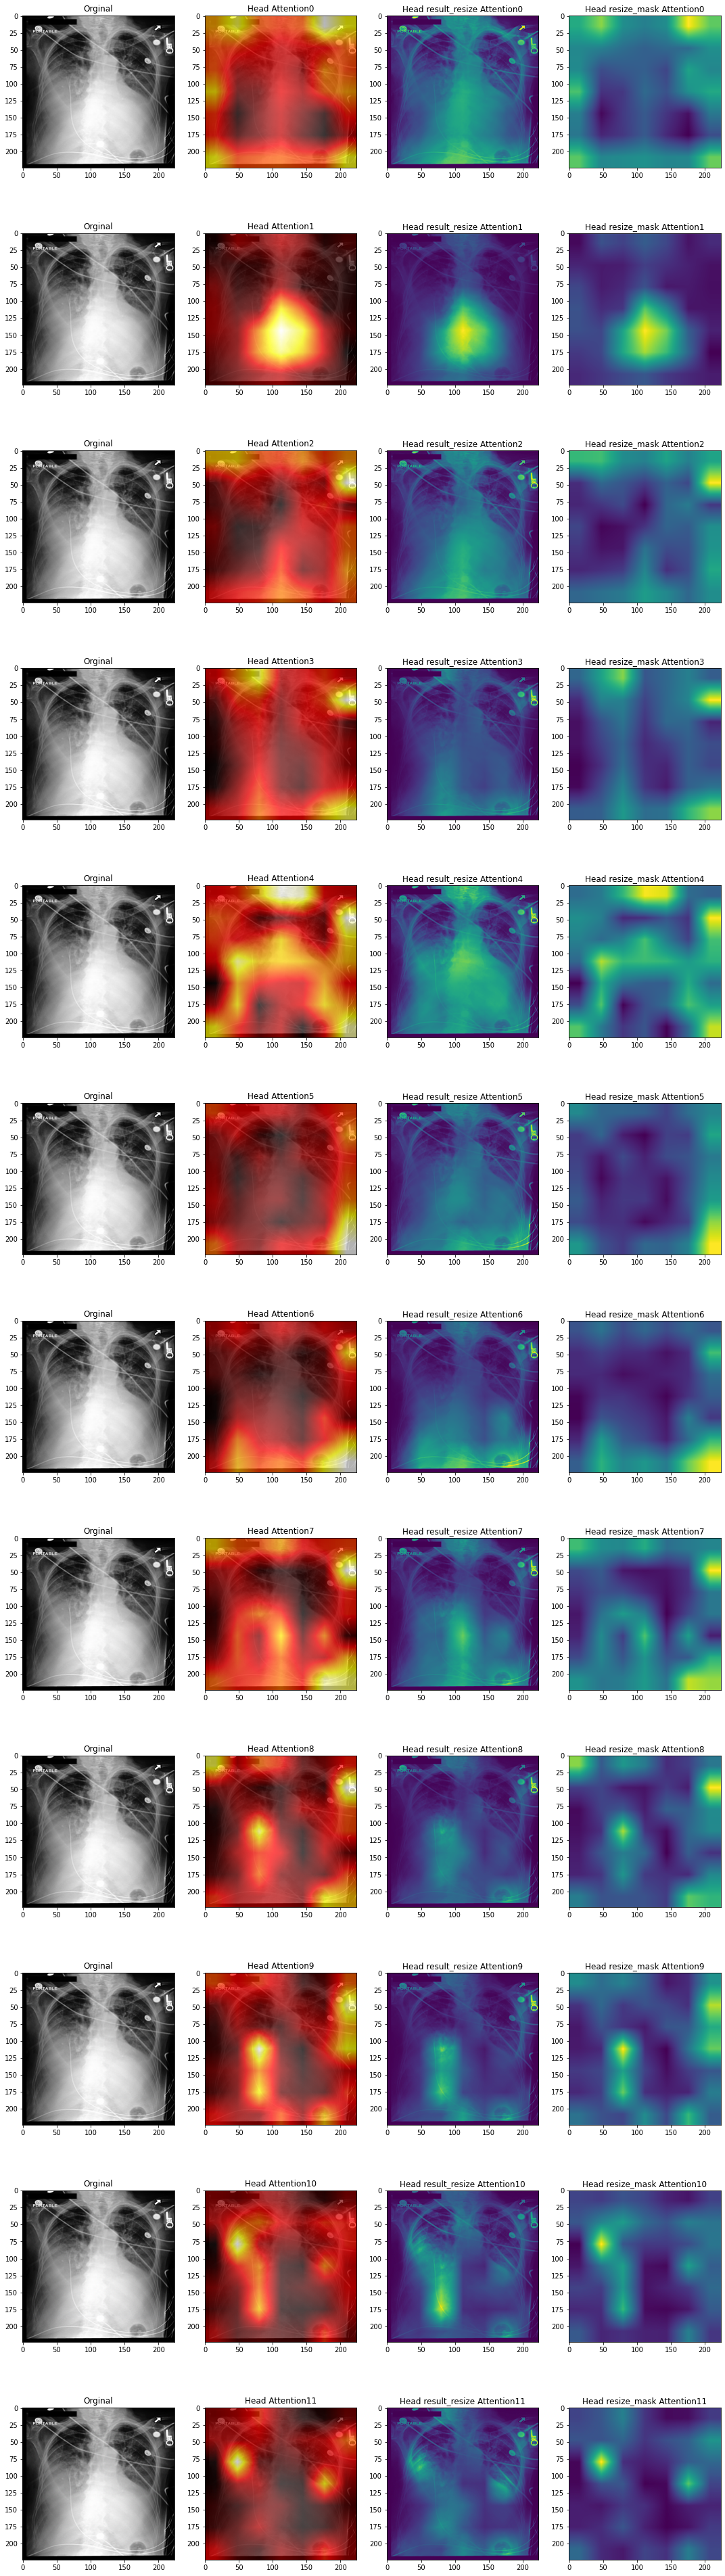

In [115]:
plot_attention_maps2(attns, img, invTrans, num_heads=12)

In [116]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
from transformers import GPT2Tokenizer
import numpy as np

from torch import nn as nn
import torch.nn.functional as F
def generate(image, context, ntok=20):
    for _ in range(ntok):
        out = model({'image': image,'input_ids': context })
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        # EOC
        if next_tok ==  50259:
            break
        context = torch.cat([context, next_tok.unsqueeze(-1)], dim=-1)
    return context


tokenizer = datamodule.train_dataset.tokenizer

In [117]:
load_val = iter(val_loader)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

['<|endoftext|> <image> Output: No evidence of consolidation to suggest pneumonia is seen.  There is some retrocardiac atelectasis.  A small left pleural effusion may be present.  No pneumothorax is seen.  No pulmonary edema.  A right granuloma is unchanged.  The heart is mildly enlarged, unchanged.  There is tortuosity of the aorta. <EOC>']


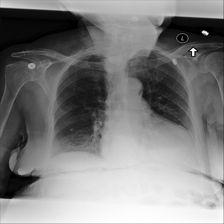

In [121]:
batch = next(load_val)
print(batch["text"]),
img_pil = T.ToPILImage()(invTrans(batch["image"])[0])
img_pil

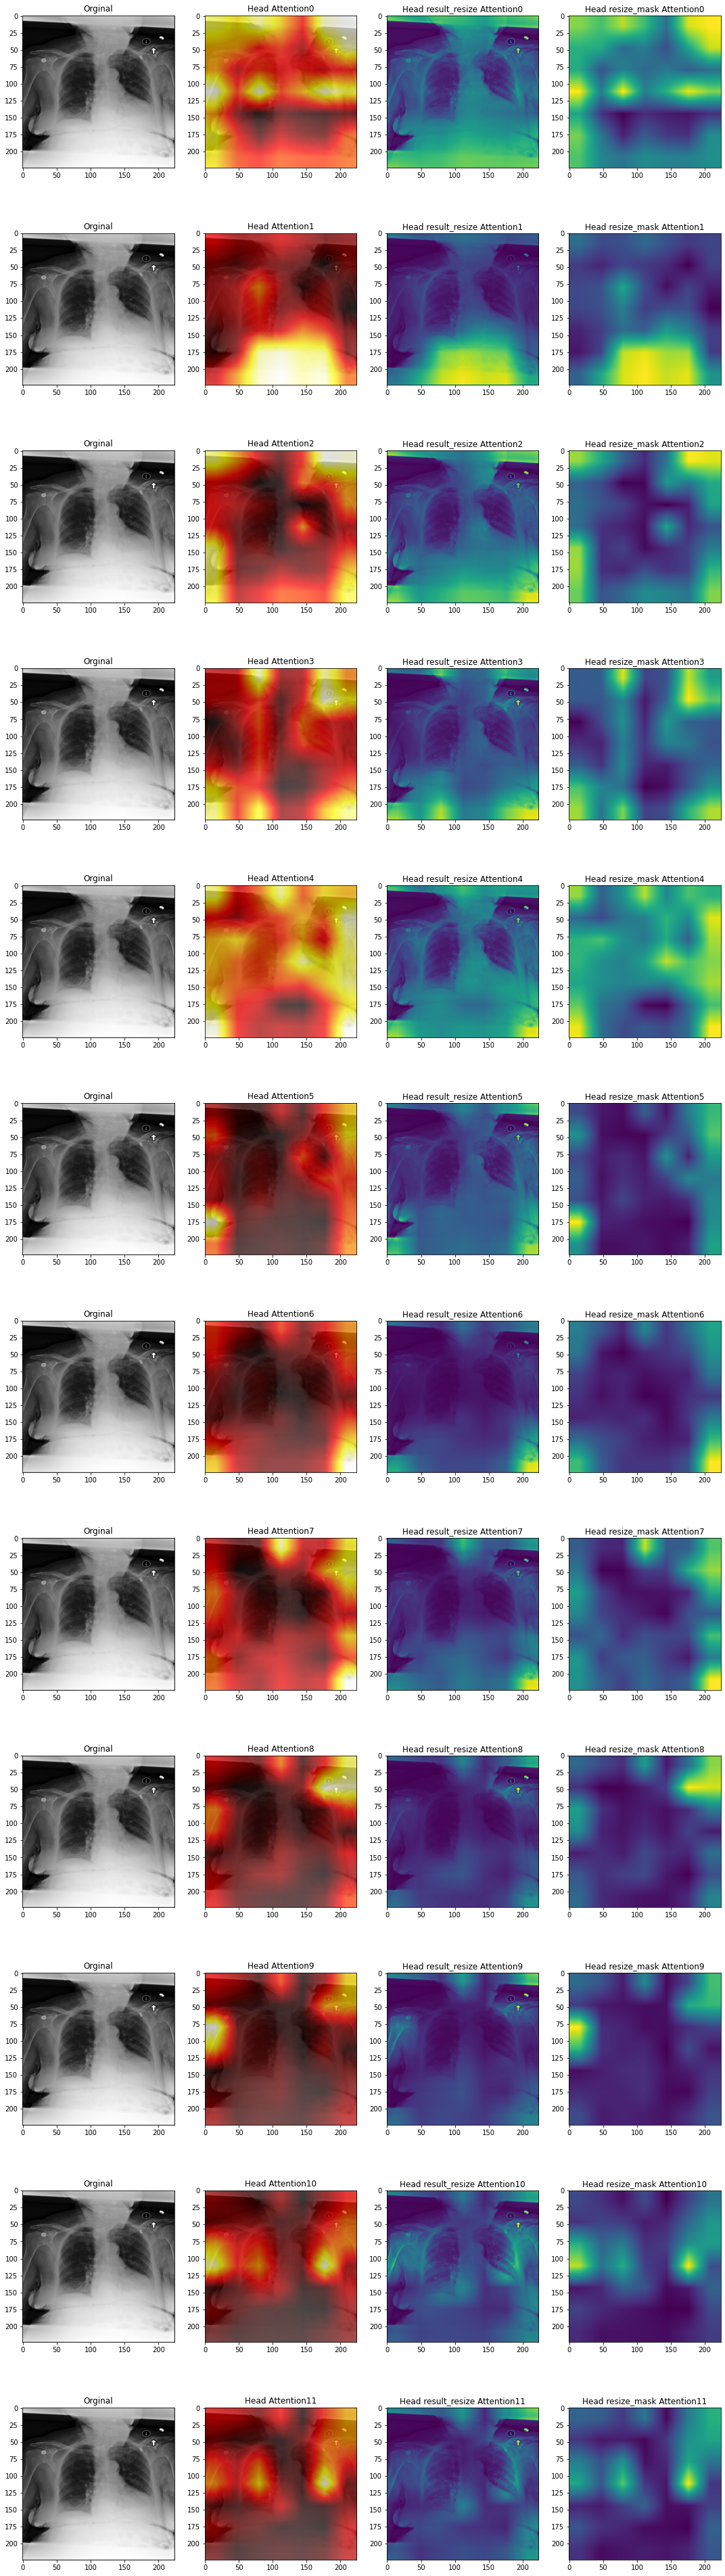

In [122]:
out, attns = model(batch, return_attn = True)
plot_attention_maps2(attns, batch["image"], invTrans, num_heads=12)

In [124]:
context   = torch.tensor([tokenizer.encode('<|endoftext|> <image> Output: ')])
out = generate(batch["image"], context, ntok=180)
tokenizer.decode(out[0])

'<|endoftext|> <image> Output:  The lungs are relatively low in volume, producing mild atelectasis at the left base and a mild to moderate left effusion.  Upper lungs are clear.  Heart is mildly enlarged, but there is no pulmonary vascular congestion. '

In [126]:
validation_dataset = datamodule.validation_dataset

In [100]:
test_loader = datamodule.test_dataloader()

In [101]:
from tqdm import tqdm as tqdm

In [102]:
gts = {}
preds = {}
for i,batch in tqdm(enumerate(val_loader)):
    context   = torch.tensor([tokenizer.encode('<|endoftext|> <image> Output: ')])
    out = generate(batch["image"], context, ntok=180)
    models_output = tokenizer.decode(out[0])

    preds[i] = [models_output.split('<|endoftext|> <image> Output:')[1].split('<EOC>')[0].rstrip().strip()]
    
    gts[i] = [batch["text"][0].split('<|endoftext|> <image> Output:')[1].split('<EOC>')[0].rstrip().strip()]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

855it [1:05:26,  4.59s/it]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KeyboardInterrupt: 

In [103]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

In [104]:
class MIMICEvalCap:
    def __init__(self, true_gt, preds):

        self.preds = preds
        self.true_gts = true_gt

        self.eval = dict()
        self.imgToEval = dict()

    def preprocess(self, s):
        s = s.replace('\n', '')
        s = s.replace('<s>', '')
        s = s.replace('</s>', '')
        # s = s.translate(str.maketrans('', '', '0123456789'))
        # s = s.translate(str.maketrans('', '', string.punctuation))
        return s

    def evaluate(self):

        gts = dict()
        res = dict()

        # Sanity Checks
        assert len(self.preds.keys()) == len(self.true_gts.keys())

        # =================================================
        # Pre-process sentences
        # =================================================
        #print('tokenization...')
        #for i in range(self.pred_df.shape[0]):
        #    pred_text = ' '.join(word_tokenize(self.preprocess(self.pred_df[i][0])))
        #    true_text = ' '.join(word_tokenize(self.preprocess(self.true_df[i][0])))

        #    res[i] = [pred_text]
        #    gts[i] = [true_text]
        
        res = self.preds
        gts = self.true_gts

        # =================================================
        # Set up scorers
        # =================================================
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr"),
            (Spice(), "SPICE")
        ]

        # =================================================
        # Compute scores
        # =================================================
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, gts.keys(), m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, gts.keys(), method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = dict()
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

In [127]:
MIMICEvalCap(gts, preds).evaluate()

setting up scorers...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
computing Bleu score...
{'testlen': 30145, 'reflen': 26426, 'guess': [30145, 29299, 28453, 27615], 'correct': [4461, 858, 209, 60]}
ratio: 1.1407326118216476
Bleu_1: 0.148
Bleu_2: 0.066
Bleu_3: 0.032
Bleu_4: 0.016
computing METEOR score...
METEOR: 0.091
computing Rouge score...
ROUGE_L: 0.125
computing CIDEr score...
CIDEr: 0.186
computing SPICE score...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_

Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4 sec].
Loading classif

Parsing test captions
Threads( StanfordCoreNLP ) [2.735 seconds]
Error: Could not cache item to /home/mlmi-matthias/anaconda3/envs/mlmi_caghan/lib/python3.9/site-packages/pycocoevalcap/spice/cache with key:
"Prior chest radiographs since ___, most recently ___ and ___.  Large areas of heterogeneous pulmonary consolidation and cavitation in the right lung have improved.  The rapidity of this is probably a combination of mild to moderate pulmonary edema, including large areas of consolidation, and cavitation and nodular quality in the right lung, has decreased since ___.  Moderate cardiomegaly has not changed appreciably over this period although there may have been a component of cardiac decompensation.  There is no pneumothorax."
Caption may be too long
Error: Could not cache item to /home/mlmi-matthias/anaconda3/envs/mlmi_caghan/lib/python3.9/site-packages/pycocoevalcap/spice/cache with key:
"A right internal jugular central venous catheter has its tip in the proximal right atrium.  R

SPICE evaluation took: 12.61 s
SPICE: 0.072
